# Image Colorization Using GANs

https://www.kaggle.com/code/ziyadelshazly/image-colorization-using-gans

In [1]:
import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2
from tensorflow.keras.layers import Input,Dense,Reshape,Conv2D,Dropout,multiply,Dot,Concatenate,subtract,ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization,LeakyReLU,Flatten
from tensorflow.keras.layers import Conv2DTranspose as Deconv2d
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras import backend as K
import smtplib
from sklearn.utils import shuffle
import tensorflow as tf
import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm
import re
from keras.preprocessing.image import img_to_array

In [2]:
# to get the files in proper order
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)

SIZE = 256
N = 100

color_img = []
path = os.path.join('..', 'data', 'train', 'opt')
files = os.listdir(path)
files = sorted_alphanumeric(files)
for file in tqdm(files[:N]):
    img = cv2.imread(os.path.join(path, file),1)
    # open cv reads images in BGR format so we have to convert it to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #resizing image
    img = cv2.resize(img, (SIZE, SIZE))
    img = img.astype('float32') / 255.0
    color_img.append(img_to_array(img))


gray_img = []
path = os.path.join('..', 'data', 'train', 'sar')
files = os.listdir(path)
files = sorted_alphanumeric(files)
for file in tqdm(files[:N]):
    img = cv2.imread(os.path.join(path, file),1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #resizing image
    img = cv2.resize(img, (SIZE, SIZE))
    img = img.astype('float32') / 255.0
    gray_img.append(img_to_array(img))


100%|██████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 671.42it/s]


In [3]:
color_dataset=tf.data.Dataset.from_tensor_slices(np.array(color_img[:2000])).batch(64)
gray_dataset=tf.data.Dataset.from_tensor_slices(np.array(gray_img[:2000])).batch(64)

color_dataset_t=tf.data.Dataset.from_tensor_slices(np.array(color_img[2000:])).batch(8)
gray_dataset_t=tf.data.Dataset.from_tensor_slices(np.array(gray_img[2000:])).batch(8)

In [4]:
example_color = next(iter(color_dataset))
example_gray = next(iter(gray_dataset))

In [5]:
def plot_images(n):
    for i in range(n):
        plt.figure(figsize = (10,10))
        plt.subplot(121)
        plt.title('color')
        plt.imshow(example_color[i] )

        plt.subplot(122)
        plt.title('gray')
        plt.imshow(example_gray[i])
        plt.show()

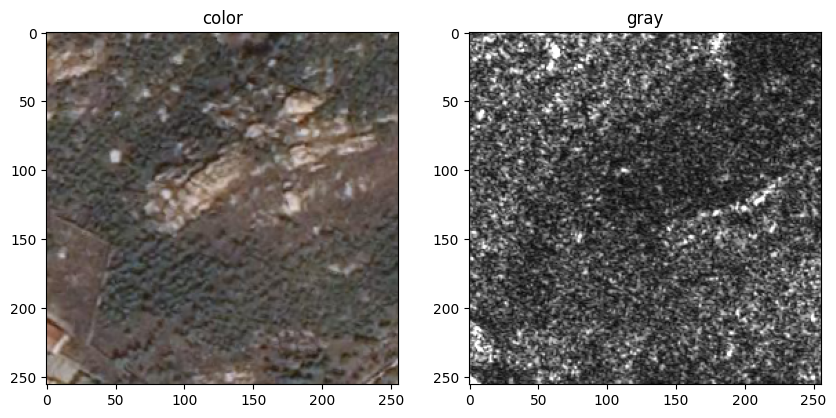

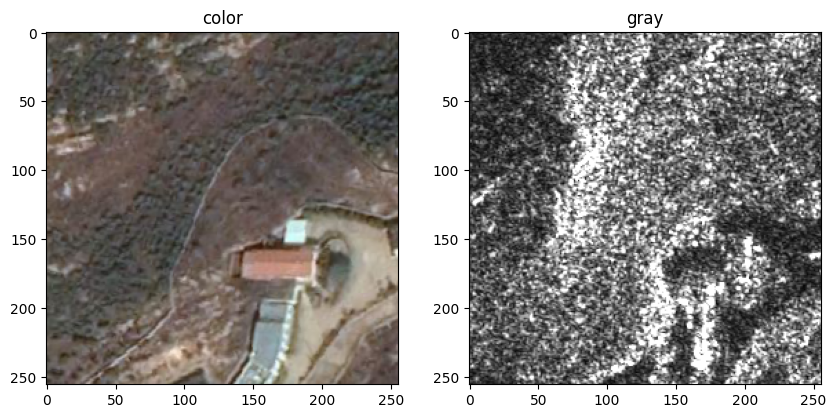

In [6]:
plot_images(2)

## Modeling

In [7]:
def downsample(filters, size, apply_batchnorm=True):

  result = tf.keras.Sequential()
  result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())
  return result

def upsample(filters, size, apply_dropout=False):

  result = tf.keras.Sequential()
  result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())
  return result

## Generator

In [8]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256,256,3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(3, 4,strides=2,padding='same',kernel_initializer=initializer,activation='tanh') # (bs, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

## Discriminator

In [9]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [10]:
generator = Generator()
generator.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential (Sequential)       │ (None, 128, 128, 64)      │           3,072 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential_1 (Sequential)     │ (None, 64, 64, 128)       │         131,584 │ sequential[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential_2 (Sequential)     │ (None, 32, 32, 256)       │         525,312 │ sequential_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential_3 (Sequential)     │ (None, 16, 16, 512)       │       2,099,200 │ sequential_2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential_4 (Sequential)     │ (None, 8, 8, 512)         │       4,196,352 │ sequential_3[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential_5 (Sequential)     │ (None, 4, 4, 512)         │       4,196,352 │ sequential_4[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential_6 (Sequential)     │ (None, 2, 2, 512)         │       4,196,352 │ sequential_5[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential_7 (Sequential)     │ (None, 1, 1, 512)         │       4,196,352 │ sequential_6[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential_8 (Sequential)     │ (None, 2, 2, 512)         │       4,196,352 │ sequential_7[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 2, 2, 1024)        │               0 │ sequential_8[0][0],        │
│                               │                           │                 │ sequential_6[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential_9 (Sequential)     │ (None, 4, 4, 512)         │       8,390,656 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_1 (Concatenate)   │ (None, 4, 4, 1024)        │               0 │ sequential_9[0][0],        │
│                               │                           │                 │ sequential_5[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential_10 (Sequential)    │ (None, 8, 8, 512)         │       8,390,656 │ concatenate_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_2 (Concatenate)   │ (None, 8, 8, 1024)        │               0 │ sequential_10[0][0],       │
│                               │                           │                 │ sequential_4[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential_11 (Sequential)    │ (None, 16, 16, 512)       │       8,390,65

 Total params: 54,425,859 (207.62 MB)

 Trainable params: 54,414,979 (207.58 MB)

 Non-trainable params: 10,880 (42.50 KB)

In [11]:
discriminator = Discriminator()
discriminator.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)      │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ target_image (InputLayer)     │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_7 (Concatenate)   │ (None, 256, 256, 6)       │               0 │ input_image[0][0],         │
│                               │                           │                 │ target_image[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential_15 (Sequential)    │ (None, 128, 128, 64)      │           6,144 │ concatenate_7[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential_16 (Sequential)    │ (None, 64, 64, 128)       │         131,584 │ sequential_15[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential_17 (Sequential)    │ (None, 32, 32, 256)       │         525,312 │ sequential_16[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d                │ (None, 34, 34, 256)       │               0 │ sequential_17[0][0]        │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_11 (Conv2D)            │ (None, 31, 31, 512)       │       2,097,152 │ zero_padding2d[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_16        │ (None, 31, 31, 512)       │           2,048 │ conv2d_11[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu_11 (LeakyReLU)    │ (None, 31, 31, 512)       │               0 │ batch_normalization_16[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d_1              │ (None, 33, 33, 512)       │               0 │ leaky_re_lu_11[0][0]       │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_12 (Conv2D)            │ (None, 30, 30, 1)         │           8,193 │ zero_padding2d_1[0][0]     │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,770,433 (10.57 MB)

 Trainable params: 2,768,641 (10.56 MB)

 Non-trainable params: 1,792 (7.00 KB)

## Check Loss

In [12]:
genLoss = []
discLoss = []

In [13]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

LAMBDA = 100

def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)
  genLoss.append(total_gen_loss)

  return total_gen_loss, gan_loss, l1_loss

def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss
  discLoss.append(total_disc_loss)

  return total_disc_loss

## Training Method

In [14]:
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

## Fitting Method

In [15]:
import time
def fit(train_ds, epochs,):
  for epoch in range(epochs):
    start = time.time()
    print("Epoch: ", epoch+1)
    # Train
    for n, (input_image, target) in train_ds.enumerate():
      train_step(input_image, target, epoch)
    print()
    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,time.time()-start))

## Generating Code

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8968155..0.8360178].


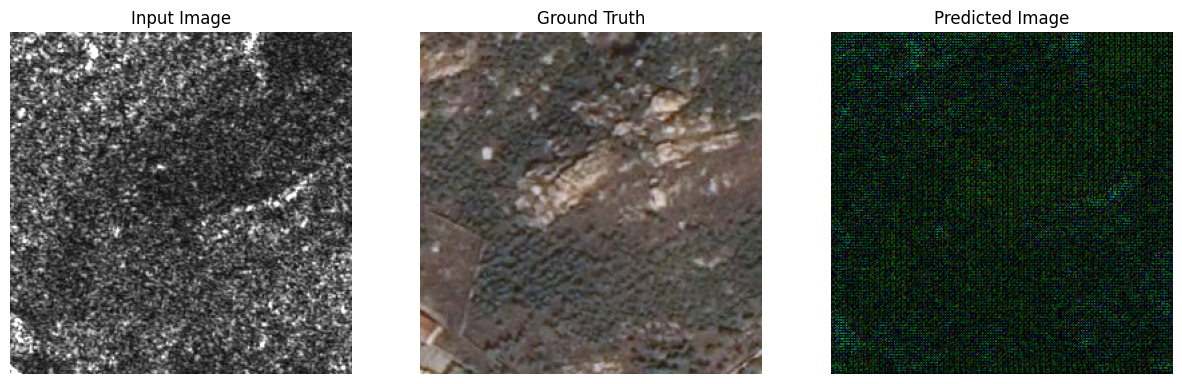

(64, 256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.93207306..0.91541237].


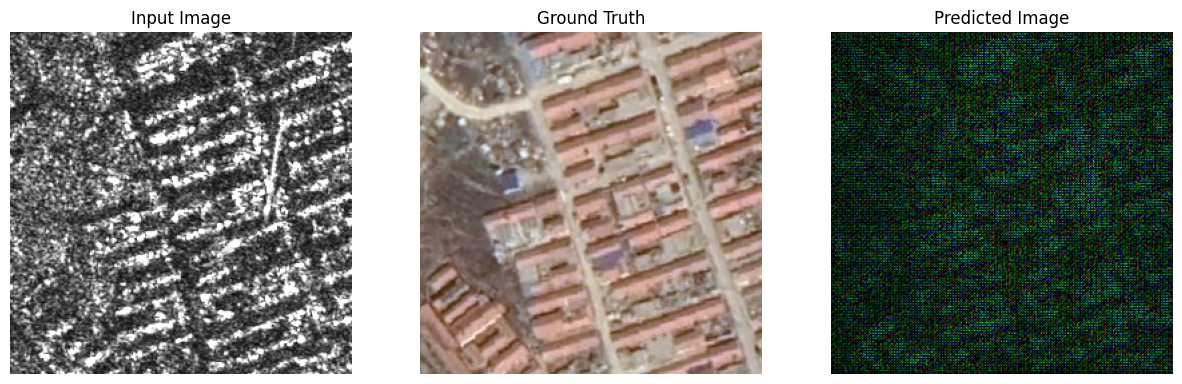

(36, 256, 256, 3)


In [16]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()

for example_input, example_target in tf.data.Dataset.zip((gray_dataset,color_dataset)).take(2):
  generate_images(generator, example_input, example_target)
  print(example_input.shape)

In [18]:
hist=fit(tf.data.Dataset.zip((gray_dataset, color_dataset)), epochs = 10)

Epoch:  1

Time taken for epoch 1 is 227.6048059463501 sec

Epoch:  2

Time taken for epoch 2 is 68.24871492385864 sec

Epoch:  3

Time taken for epoch 3 is 86.58428645133972 sec

Epoch:  4

Time taken for epoch 4 is 91.04747295379639 sec

Epoch:  5

Time taken for epoch 5 is 96.23284482955933 sec

Epoch:  6

Time taken for epoch 6 is 59.23438334465027 sec

Epoch:  7

Time taken for epoch 7 is 115.76172161102295 sec

Epoch:  8

Time taken for epoch 8 is 69.6725218296051 sec

Epoch:  9

Time taken for epoch 9 is 59.38510608673096 sec

Epoch:  10

Time taken for epoch 10 is 103.91117310523987 sec



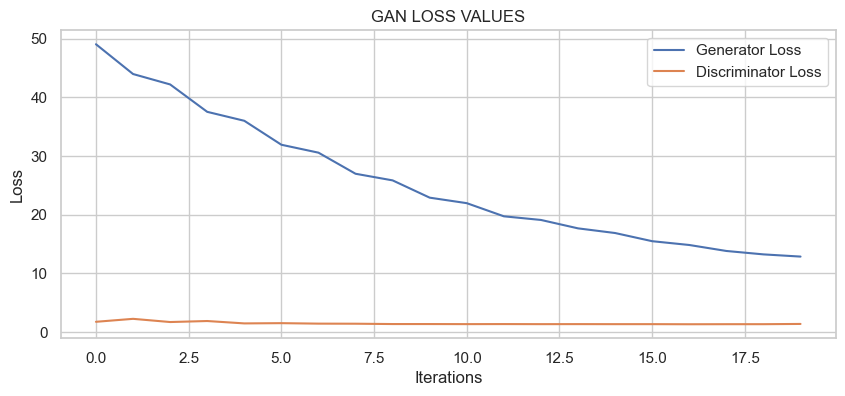

In [19]:
import seaborn as sns
sns.set(style='whitegrid')
plt.figure(figsize=(10,4))
plt.plot(genLoss, label="Generator Loss")
plt.plot(discLoss, label="Discriminator Loss")
plt.title("GAN LOSS VALUES")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5413324..0.6803832].


(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


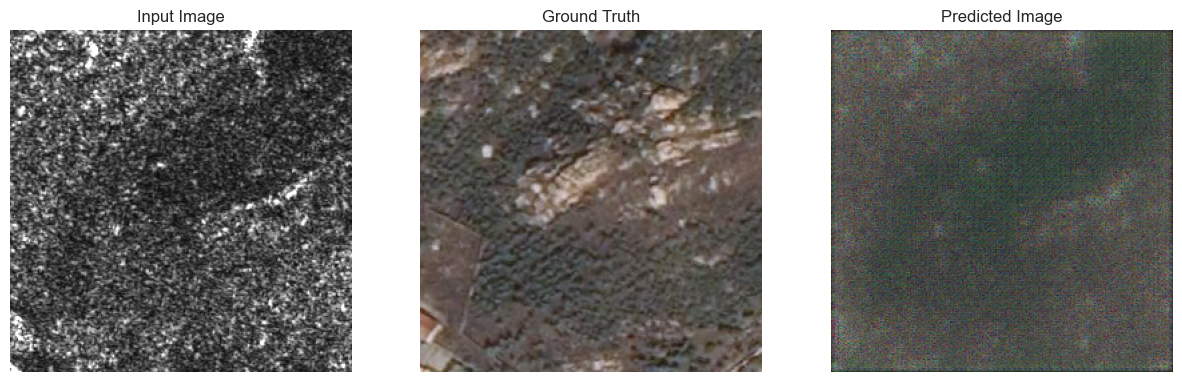

(64, 256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.68478966..0.9293797].


(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


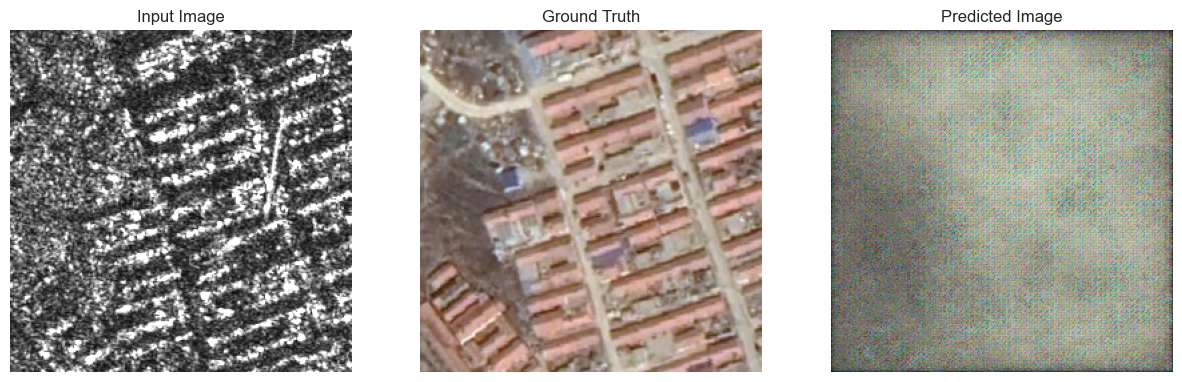

(36, 256, 256, 3)


In [20]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    print(test_input[0].shape)
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()

for example_input, example_target in tf.data.Dataset.zip((gray_dataset,color_dataset)).take(11):
  generate_images(generator, example_input, example_target)
  print(example_input.shape)

## Evaluation

### 1. Mean Squared Error (MSE)

In [27]:
def mse(image_true, image_pred):
    return np.mean((image_true - image_pred) ** 2)
for example_input, example_target in tf.data.Dataset.zip((gray_dataset,color_dataset)).take(1):
    print(mse(example_input, example_target))

0.0714554


### 2. Peak Signal-to-Noise Ratio (PSNR)

In [31]:
def psnr(image_true, image_pred):
    return cv2.PSNR(image_true, image_pred)
for example_input, example_target in tf.data.Dataset.zip((gray_dataset,color_dataset)).take(1):
    print(psnr(example_input.numpy(), example_target.numpy()))

59.590455148272554


### 3. Structural Similarity Index (SSIM)

In [33]:
from skimage.metrics import structural_similarity as ssim
def ssim_score(image_true, image_pred):
    return ssim(image_true, image_pred, win_size=3, channel_axis=-1, data_range=1.0)
ssim_score(example_input.numpy(), example_target.numpy())

np.float32(0.013621684)

### 4. Perceptual Loss (VGG Loss)

In [38]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16

def perceptual_loss(y_true, y_pred):
    # Load pre-trained VGG16
    vgg = VGG16(include_top=False, weights="imagenet")
    
    # Create a feature extractor model
    model = tf.keras.Model(inputs=vgg.input, outputs=vgg.get_layer("block3_conv3").output)

    return tf.reduce_mean(tf.square(model(y_true) - model(y_pred)))

# Convert to tensor and ensure correct dtype
tensor_img_1 = tf.convert_to_tensor(example_input.numpy(), dtype=tf.float32) / 255.0
tensor_img_ = tf.convert_to_tensor(example_target.numpy(), dtype=tf.float32) / 255.0

# 🔍 Check shape
print("Original tensor_img_1 shape:", tensor_img_1.shape)

# ✅ Only remove an extra dimension if it exists
if len(tensor_img_1.shape) == 5:  
    tensor_img_1 = tensor_img_1[:, 0, :, :, :]  # Select first frame
    tensor_img_ = tensor_img_[:, 0, :, :, :]

print("Processed tensor_img_1 shape:", tensor_img_1.shape)

# Compute perceptual loss
loss = perceptual_loss(tensor_img_1, tensor_img_)
print("Perceptual Loss:", loss.numpy())

Original tensor_img_1 shape: (64, 256, 256, 3)
Processed tensor_img_1 shape: (64, 256, 256, 3)
Perceptual Loss: 0.005862141


## Saving the model

In [39]:
generator.save('../models/GAN-colorization.keras')